# Merge 

Combine the CIEP and ETP datasets.

Try to remove duplicated entries.

We are not using CIEP with the concatenated lines because some lines are missing and the translations wouldn't make sense

In [1]:
import pandas as pd
import numpy as np
import Levenshtein
import re
import matplotlib.pyplot as plt

In [2]:
etp = pd.read_csv("../ETP_fix.csv", index_col=0)
ciep = pd.read_csv("../CIEP_pymupdf.csv")

In [3]:
etp

,ID,City,Year - From,Year - To,Etruscan,Translation
0,ETP 192,Ager Tarquiniensis,275.0,250.0,cleusinas : laris : larisal : clan,"Laris Cleusinas, son of Laris."
1,Cr 2.20,Caere,675.0,650.0,mi karkanas θahvna,I (am) the container of Karkana
2,Cm 2.46,Campania,500.0,450.0,mi e.i. mi.n.pi capi mi numar | θevru.c.l.na....,'Don't take me. I (am) nunar. (I am the prope...
3,ETP 269,NaN,625.0,600.0,mini muluvanice tetana ve.l.ka.s.na.s. veleli...,Tetana Velkasnas gave me to Velellia.
4,Ta 3.2,Tarquinia,580.0,580.0,itun turuce vene.l a.telinas. tinas dlniiaras,Venel Atelinas dedicated this (vase) to the s...
...,...,...,...,...,...,...
556,ETP 365,Ager Saenensis,600.0,600.0,[---]urθ[---],NaN
557,ETP 366,Ager Saenensis,600.0,600.0,[---]alv[---],NaN
558,ETP 367,Ager Saenensis,600.0,600.0,[---]tinai[---],NaN
559,ETP 368,Ager Faesulanus,600.0,575.0,[---]nutas[---],NaN


In [4]:
ciep

,key,T,C,A,CIEP
0,2,thannia,thannia,ms-lucialauciathanniamr-,2
1,1,tularspu,NaN,boundaries,3
2,4,visl,vi(p)s(ia)l,of-the-goddess-vipsi,3
3,5,--echtatr--,NaN,NaN,3
4,2,NaN,papsinas,ofmr-aulepapsinamr-lariss,4
...,...,...,...,...,...
5828,1,pisna,NaN,NaN,21041
5829,1A,ru,NaN,mr-rufes,21046
5830,1A,ma,ma(rces),mr-marces,21065
5831,1,kakas,NaN,NaN,21072


In [5]:
def pipeline(text):
    if pd.isna(text):
        return np.nan
    text = text.lower().strip()
    return re.sub("[^a-z] *", "", text)

In [6]:
etp_etruscan = etp["Etruscan"].apply(pipeline).to_list()
etp_translation = etp["Translation"].apply(pipeline).to_list()
ciep_T = ciep["T"].apply(pipeline).to_list()
ciep_C = ciep["C"].apply(pipeline).to_list()
ciep_A = ciep["A"].apply(pipeline).to_list()

In [7]:
def compute_similarity(texts, candidates):
    sim = np.zeros((len(texts), len(candidates)))
    for i, t in enumerate(texts):
        for j, c in enumerate(candidates):
            if pd.isna(t) or pd.isna(c):
                sim[i, j] = -np.inf
            else:
                sim[i, j] = Levenshtein.ratio(t, c)
    return sim

In [8]:
T_sim = compute_similarity(ciep_T, etp_etruscan)
C_sim = compute_similarity(ciep_C, etp_etruscan)
A_sim = compute_similarity(ciep_A, etp_etruscan)

Two documents are considered the same if CIEP T or CIEP A match ETP and if the translations are the same.

In [9]:
def describe(mat, name):
    mask = mat > -np.inf
    print("{}: {} ({})".format(name, mat[mask].mean(), mat[mask].std()))
    print("--quartiles:", np.quantile(mat[mask], [0, 0.25, 0.5, 0.75, 1]))
    

describe(T_sim, "T")
describe(C_sim, "C")
describe(A_sim, "A")

T: 0.2482979434914332 (0.12157187539099563)
--quartiles: [0.         0.16666667 0.25       0.33333333 1.        ]
C: 0.27499482674200776 (0.11615163268120586)
--quartiles: [0.         0.2        0.27272727 0.35294118 1.        ]
A: 0.2603292774110014 (0.10469429626141552)
--quartiles: [0.         0.19047619 0.26470588 0.33333333 1.        ]


T and C are the same inscription, so we can take the varsion that is most similar to ETP.

Also, we are not interested in a particular couple of duplicated documents, so we can simply take the highest similary and compare it with the threshold.

In [10]:
TC_sim = np.max([T_sim, C_sim], axis=0)
TC_max_sim = TC_sim.max(1)
A_max_sim = A_sim.max(1)

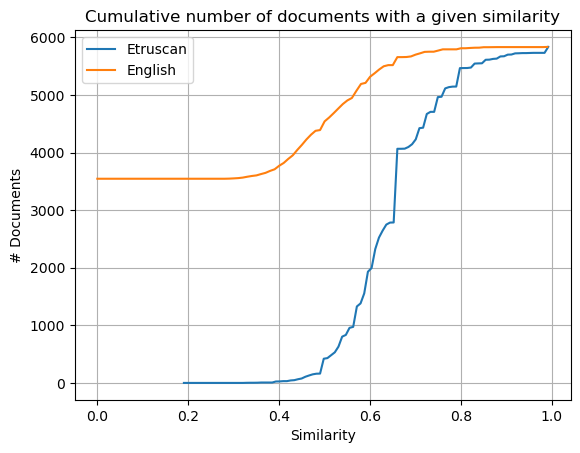

In [11]:
v, b = np.histogram(TC_max_sim, bins=100)
plt.plot(b[:-1], np.cumsum(v), label="Etruscan")
v, b = np.histogram(np.clip(A_max_sim, 0, None), bins=100)
plt.plot(b[:-1], np.cumsum(v), label="English")
plt.grid()
plt.title("Cumulative number of documents with a given similarity")
plt.ylabel("# Documents")
plt.xlabel("Similarity")
plt.legend()
plt.show()

In [12]:
def exclude(TC, A, th_ET, th_ENG):
    return ((TC > th_ET) & (A == -np.inf)) | ((TC > th_ET) & (A > th_ENG))
def count_excluded(TC, A, th_ET, th_ENG):
    return np.sum(exclude(TC, A, th_ET, th_ENG))

In [13]:
threshold_ET = 0.5
threshold_ENG = 0.5
print(f"Excluded with ({threshold_ET}, {threshold_ENG}): {count_excluded(TC_max_sim, A_max_sim, threshold_ET, threshold_ENG)}")
threshold_ET = 0.8
threshold_ENG = 0.5
print(f"Excluded with ({threshold_ET}, {threshold_ENG}): {count_excluded(TC_max_sim, A_max_sim, threshold_ET, threshold_ENG)}")

threshold_ET = 0.8
threshold_ENG = 0.8
print(f"Excluded with ({threshold_ET}, {threshold_ENG}): {count_excluded(TC_max_sim, A_max_sim, threshold_ET, threshold_ENG)}")

threshold_ET = 0.9
threshold_ENG = 0.9
print(f"Excluded with ({threshold_ET}, {threshold_ENG}): {count_excluded(TC_max_sim, A_max_sim, threshold_ET, threshold_ENG)}")

threshold_ET = 0.95
threshold_ENG = 0.95
print(f"Excluded with ({threshold_ET}, {threshold_ENG}): {count_excluded(TC_max_sim, A_max_sim, threshold_ET, threshold_ENG)}")

threshold_ET = 1
threshold_ENG = 1
print(f"Excluded with ({threshold_ET}, {threshold_ENG}): {count_excluded(TC_max_sim, A_max_sim, threshold_ET, threshold_ENG)}")

Excluded with (0.5, 0.5): 4574
Excluded with (0.8, 0.5): 324
Excluded with (0.8, 0.8): 245
Excluded with (0.9, 0.9): 100
Excluded with (0.95, 0.95): 70
Excluded with (1, 1): 0


In [14]:
threshold_ET = 0.8
threshold_ENG = 0.5
excluded = exclude(TC_max_sim, A_max_sim, threshold_ET, threshold_ENG)

In [15]:
ciep[~excluded].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5509 entries, 1 to 5832
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     5509 non-null   object
 1   T       3733 non-null   object
 2   C       2845 non-null   object
 3   A       2195 non-null   object
 4   CIEP    5509 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 258.2+ KB


In [17]:
keep_ciep = ciep[~excluded]

In [35]:
keep_ciep_T = keep_ciep[["T", "A", "CIEP", "key"]].dropna(subset="T")
keep_ciep_T = keep_ciep_T.rename(columns={"CIEP": "ID", "T": "Etruscan", "A": "Translation", "key": "key"})
keep_ciep_C = keep_ciep[["C", "A", "CIEP", "key"]].dropna(subset="C")
keep_ciep_C = keep_ciep_C.rename(columns={"CIEP": "ID", "C": "Etruscan", "A": "Translation", "key": "key"})

In [40]:
et_dataset = pd.concat([etp, keep_ciep_T, keep_ciep_C])
et_dataset

,ID,City,Year - From,Year - To,Etruscan,Translation,key
0,ETP 192,Ager Tarquiniensis,275.0,250.0,cleusinas : laris : larisal : clan,"Laris Cleusinas, son of Laris.",NaN
1,Cr 2.20,Caere,675.0,650.0,mi karkanas θahvna,I (am) the container of Karkana,NaN
2,Cm 2.46,Campania,500.0,450.0,mi e.i. mi.n.pi capi mi numar | θevru.c.l.na....,'Don't take me. I (am) nunar. (I am the prope...,NaN
3,ETP 269,NaN,625.0,600.0,mini muluvanice tetana ve.l.ka.s.na.s. veleli...,Tetana Velkasnas gave me to Velellia.,NaN
4,Ta 3.2,Tarquinia,580.0,580.0,itun turuce vene.l a.telinas. tinas dlniiaras,Venel Atelinas dedicated this (vase) to the s...,NaN
...,...,...,...,...,...,...,...
5815,20926,NaN,NaN,NaN,reithu,NaN,1
5819,20982,NaN,NaN,NaN,e(cnatn)i(al),NaN,2
5822,21003,NaN,NaN,NaN,i(vn(i)i),NaN,1C
5830,21065,NaN,NaN,NaN,ma(rces),mr-marces,1A


In [41]:
print("Unique IDs:", len(set(et_dataset["ID"].to_list())))
print("Etruscan texts:", len(et_dataset["Etruscan"].dropna()))
print("Translation texts:", len(et_dataset["Translation"].dropna()))

Unique IDs: 4759
Etruscan texts: 7139
Translation texts: 2891


In [42]:
et_dataset.to_csv("../Etruscan.csv")